In [11]:
import pandas as pd
from plotnine import *

filename = 'overhead.csv'
data = pd.read_csv(filename)

total_columns = ['Init','ConfigFile','SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute']
setup_columns = ['Init','ConfigFile']
stepping_columns = ['SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute']

data['Total Time (s)'] = data[['Init','ConfigFile','SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute']].sum(axis=1) 
data['Setup Time (s)'] = data[['Init','ConfigFile']].sum(axis=1)
data['Surface Time (s)'] = data[['SurfaceSetting','SurfaceCompute']].sum(axis=1)
data['Interior Time (s)'] = data[['InteriorSetting','InteriorCompute']].sum(axis=1)
data['Stepping Time (s)'] = data['Surface Time (s)'] + data['Interior Time (s)']
data = data.drop('IO', axis=1)
data['OceanColumns'] = 5 * data['NumRuns']
data

,Version,NumRuns,ConfigFile,Init,SurfaceSetting,SurfaceCompute,InteriorSetting,InteriorCompute,Total Time (s),Setup Time (s),Surface Time (s),Interior Time (s),Stepping Time (s),OceanColumns
0,Fortran,1,0.020000,0.067100,0.000000,0.000100,0.000000,0.000900,0.088100,0.087100,0.000100,0.000900,0.001000,5
1,Chapel,1,0.005106,0.061037,0.000015,0.000143,0.001904,0.000939,0.069144,0.066143,0.000158,0.002843,0.003001,5
2,Fortran,5,0.082000,0.240400,0.000000,0.000300,0.000100,0.004300,0.327100,0.322400,0.000300,0.004400,0.004700,25
3,Chapel,5,0.027141,0.219758,0.000080,0.000562,0.012191,0.004523,0.264255,0.246899,0.000642,0.016714,0.017356,25
4,Fortran,10,0.132000,0.456100,0.000000,0.000500,0.000100,0.008600,0.597300,0.588100,0.000500,0.008700,0.009200,50
5,Chapel,10,0.049441,0.420205,0.000159,0.001078,0.017644,0.008572,0.497099,0.469646,0.001237,0.026216,0.027453,50
6,Fortran,50,0.355000,2.191900,0.000100,0.002200,0.000400,0.042600,2.592200,2.546900,0.002300,0.043000,0.045300,250
7,Chapel,50,0.245575,2.022330,0.000793,0.005232,0.082105,0.042327,2.398362,2.267905,0.006025,0.124432,0.130457,250
8,Fortran,100,0.936000,4.287500,0.000200,0.004500,0.000900,0.084900,5.314000,5.223500,0.004700,0.085800,0.090500,500
9,Chapel,100,0.504298,4.040690,0.001597,0.010444,0.202715,0.084695,4.844439,4.544988,0.012041,0.287410,0.299451,500


In [12]:
chapel = data[data['Version'] == 'Chapel'].set_index('NumRuns')
fortran = data[data['Version'] == 'Fortran'].set_index('NumRuns')

overheads = ((chapel['Total Time (s)'] - fortran['Total Time (s)']) / fortran['Total Time (s)']) * 100
overheads

NumRuns
1     -21.516459
5     -19.212779
10    -16.775657
50     -7.477741
100    -8.836300
500    -3.912519
Name: Total Time (s), dtype: float64

/global/homes/n/neth/.local/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 6 rows containing missing values.


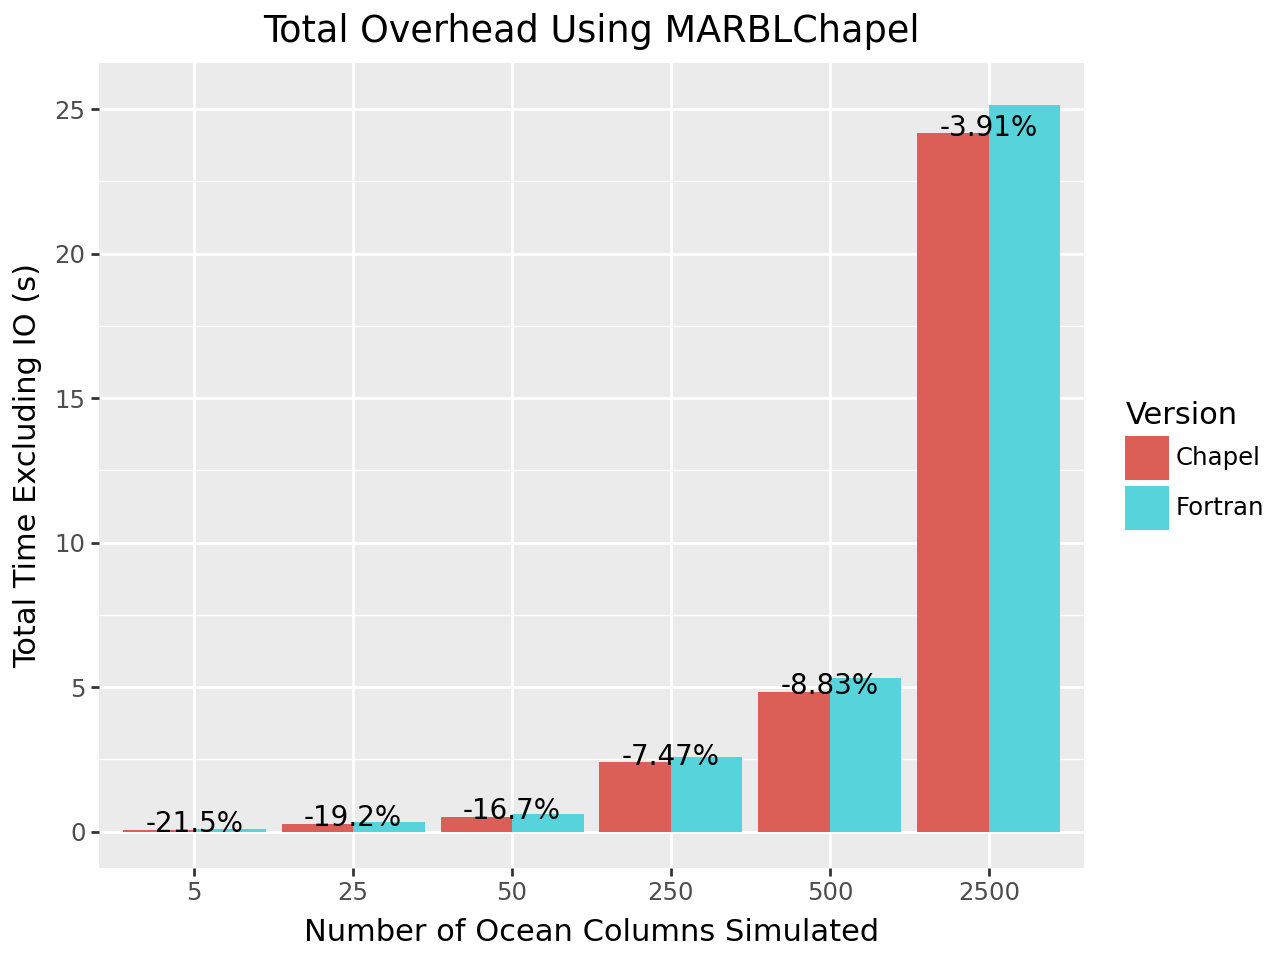

In [13]:
# Overall performance comparison
overhead_df = pd.DataFrame({'NumRuns':overheads.index, 'Label': overheads.values})
overhead_df

merged = data.merge(overhead_df)
merged

merged['Label'] = merged['Label'].astype(str).str[0:5] + "%"
merged['Label'] = merged.apply(lambda row : row['Label'] if row['Version'] == 'Chapel' else None, axis=1)
p = ggplot(merged, aes(x='factor(OceanColumns)', y='Total Time (s)', fill='Version')) + geom_bar(position='dodge', stat='identity') + geom_text(aes(label='Label'), nudge_y=0.2, size=10)
p = p + labs (x='Number of Ocean Columns Simulated', y='Total Time Excluding IO (s)',title='Total Overhead Using MARBLChapel')
p 

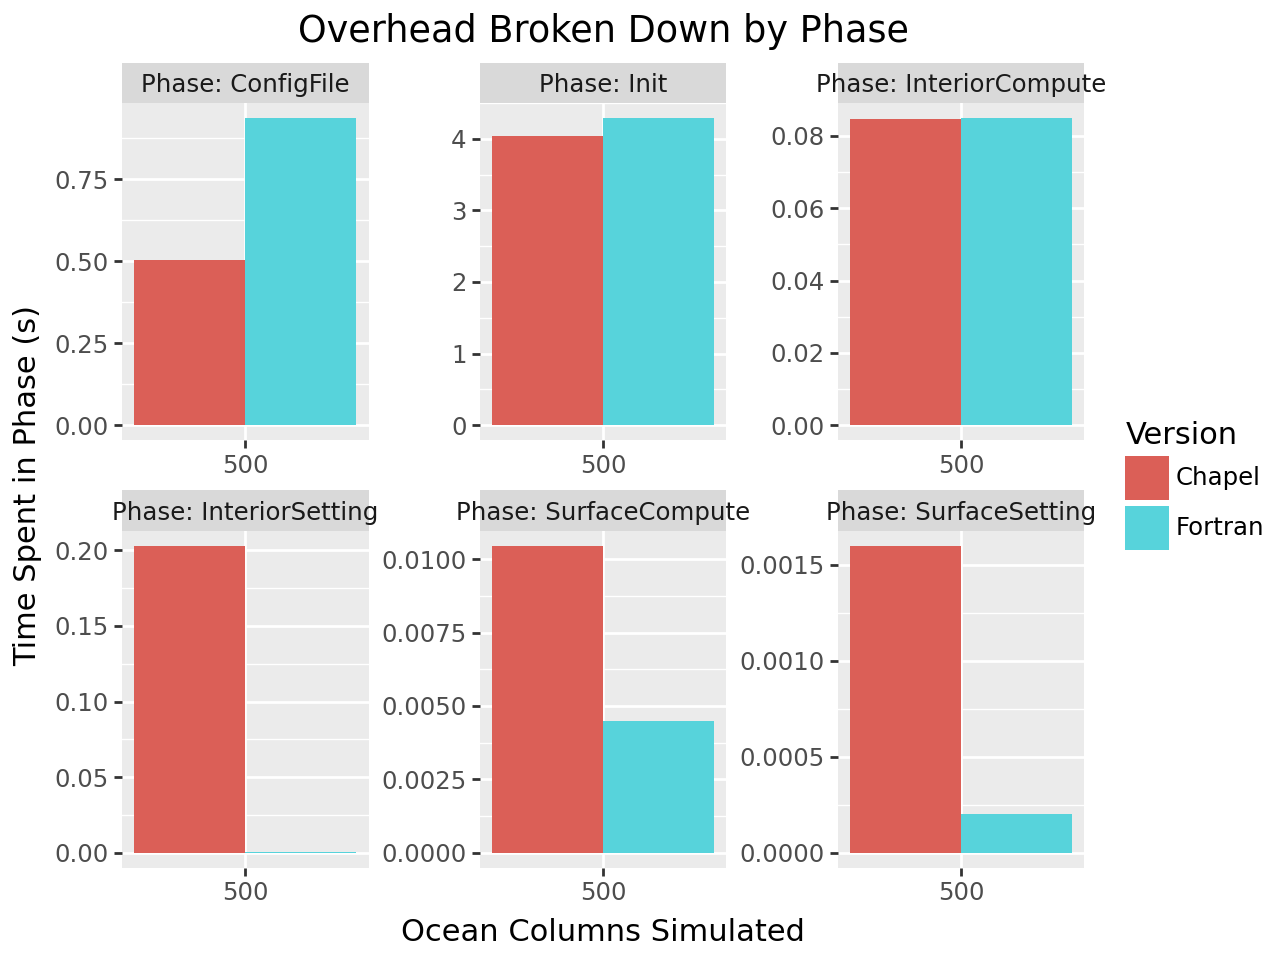

In [14]:
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=['Init','ConfigFile','SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute'],
    var_name='Phase',
    value_name='Time'
)
melted
melted = melted[melted['NumRuns'] == 100]
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Phase',scales='free' ,labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase')
p

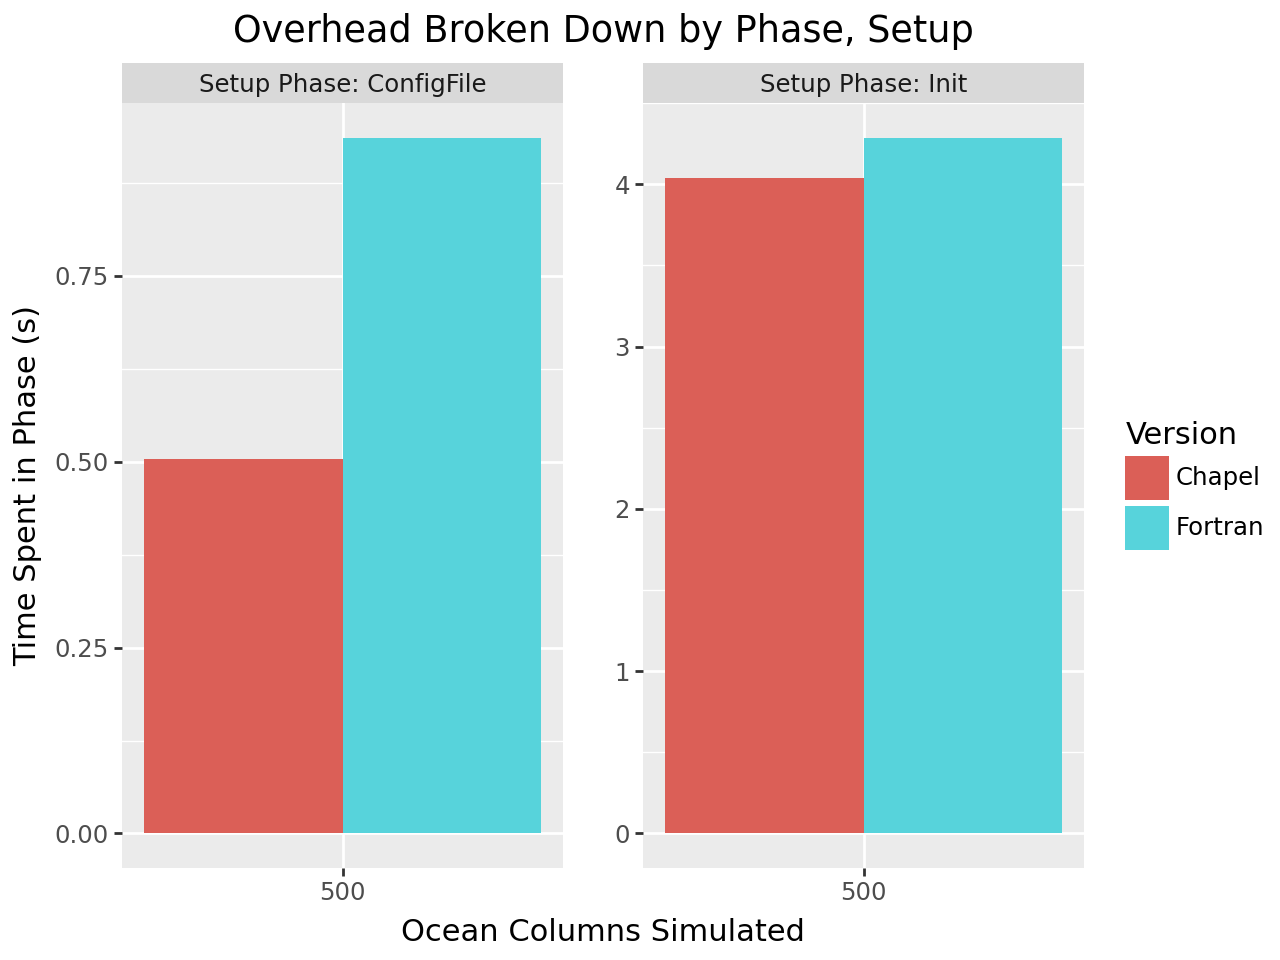

In [20]:
# Break down the overhead by its phase type. Starting with setup
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=setup_columns,
    var_name='Setup Phase',
    value_name='Time'
)
melted
melted = melted[melted['NumRuns'] == 100]
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Setup Phase',scales='free' ,labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase, Setup')
p

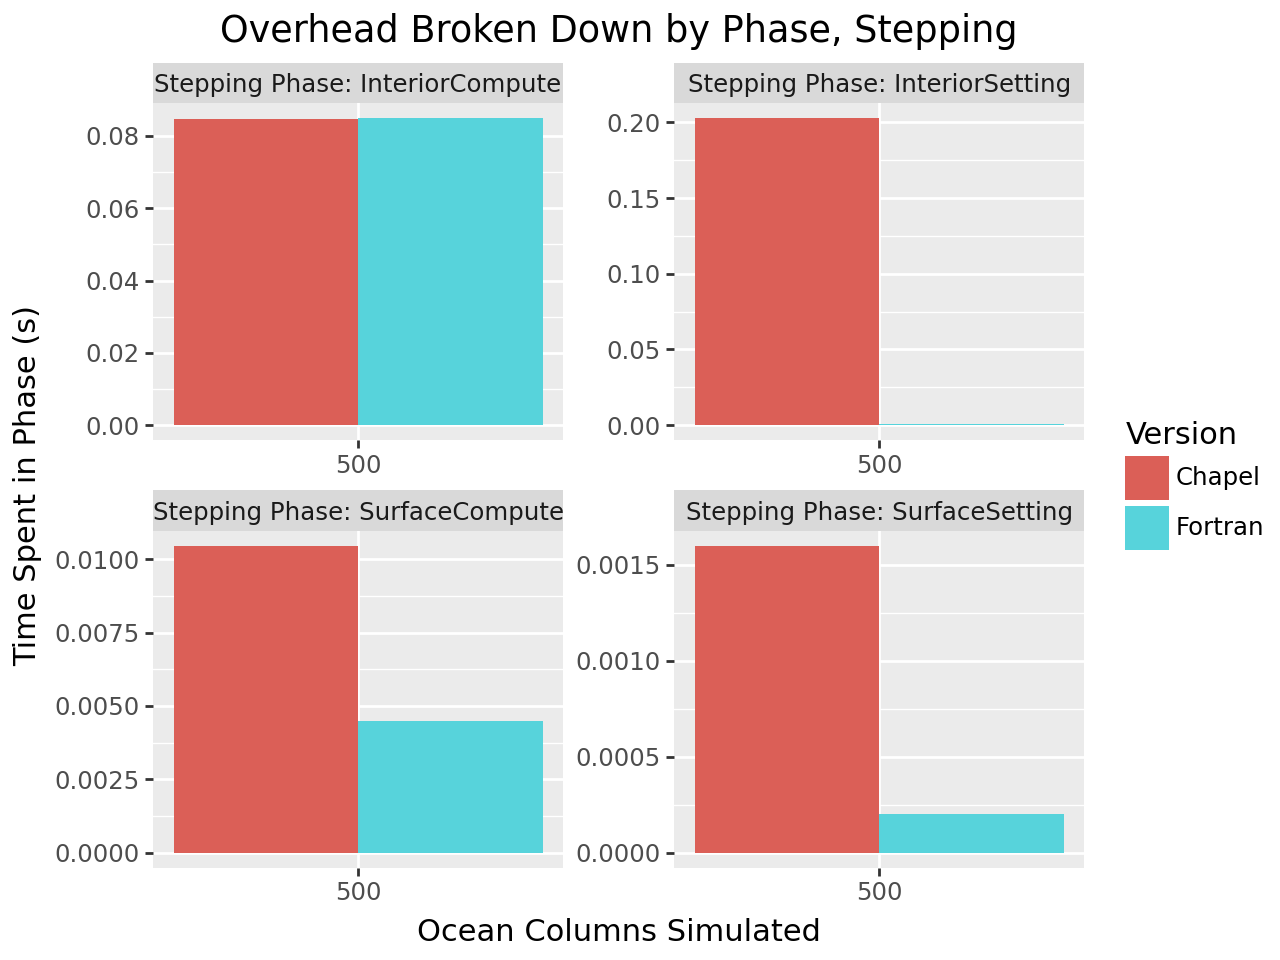

In [ ]:
# Same for stepping
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=stepping_columns,
    var_name='Stepping Phase',
    value_name='Time'
)
melted
melted = melted[melted['NumRuns'] == 100]
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Stepping Phase' ,labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase, Stepping')
p

In [16]:
# Plot for setup stuff
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Setup Time (s)', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Phase',labeller='label_both')

In [17]:
# Now need to make the scaling plots
weak_data = pd.read_csv('weak-scaling.csv')
strong_data = pd.read_csv('strong-scaling.csv')

strong_data['TotalColumns'] = strong_data['NodeCount'] * strong_data['RunsPerNode'] * 5

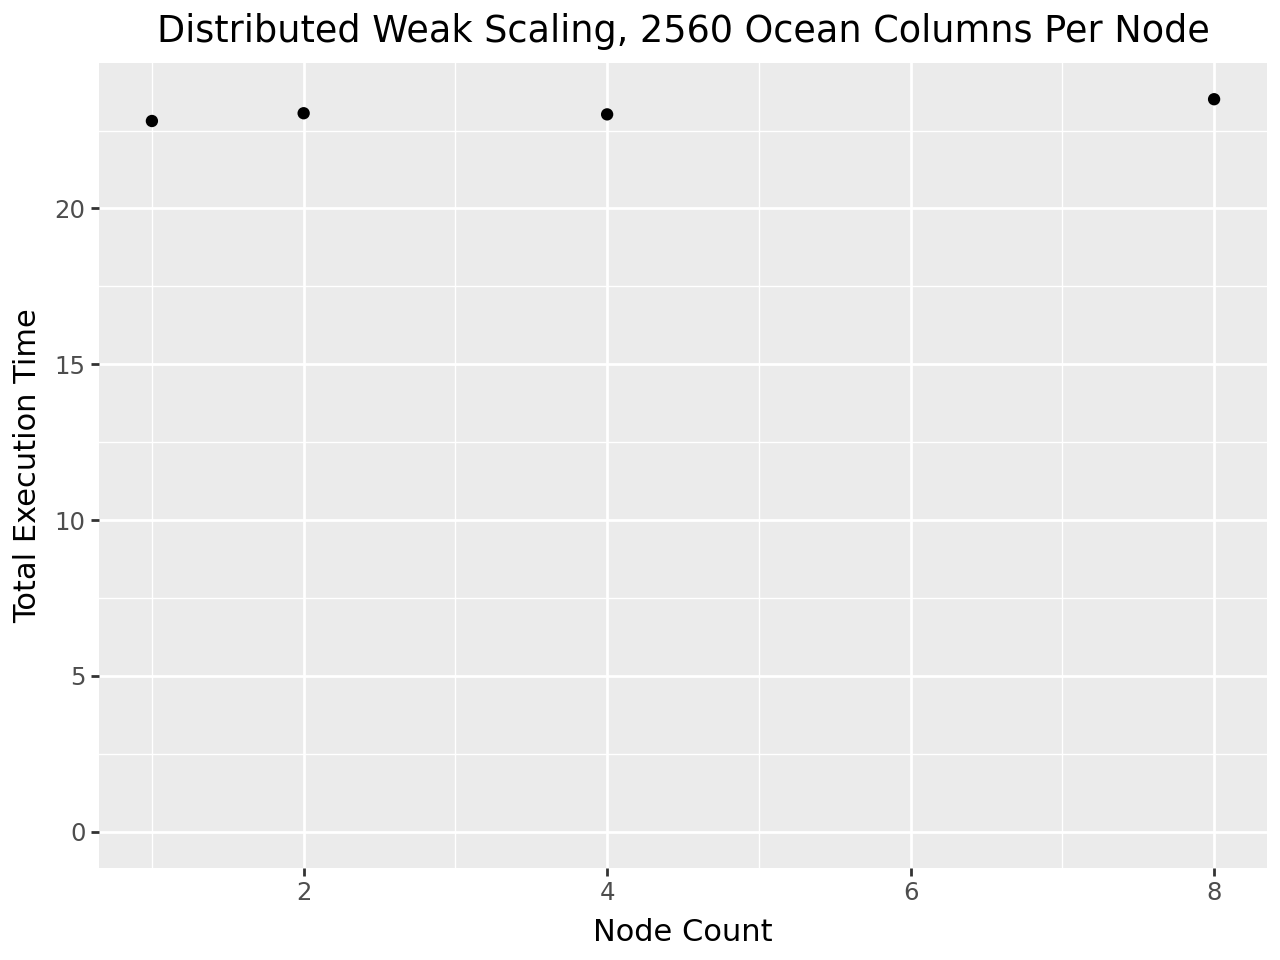

In [18]:
# Weak scaling plot
p = ggplot(weak_data, aes(x='NodeCount', y='Time')) + geom_point()
p = p + labs(x="Node Count", y='Total Execution Time', title="Distributed Weak Scaling, 2560 Ocean Columns Per Node")
p = p + scale_y_continuous(limits=(0,None))
p

   NodeCount  Series  Total Execution Time
0          1   Ideal              22.68960
1          2   Ideal              11.34480
2          4   Ideal               5.67240
3          8   Ideal               2.83620
4          1  Actual              22.68960
5          2  Actual              11.57410
6          4  Actual               5.87384
7          8  Actual               3.01428


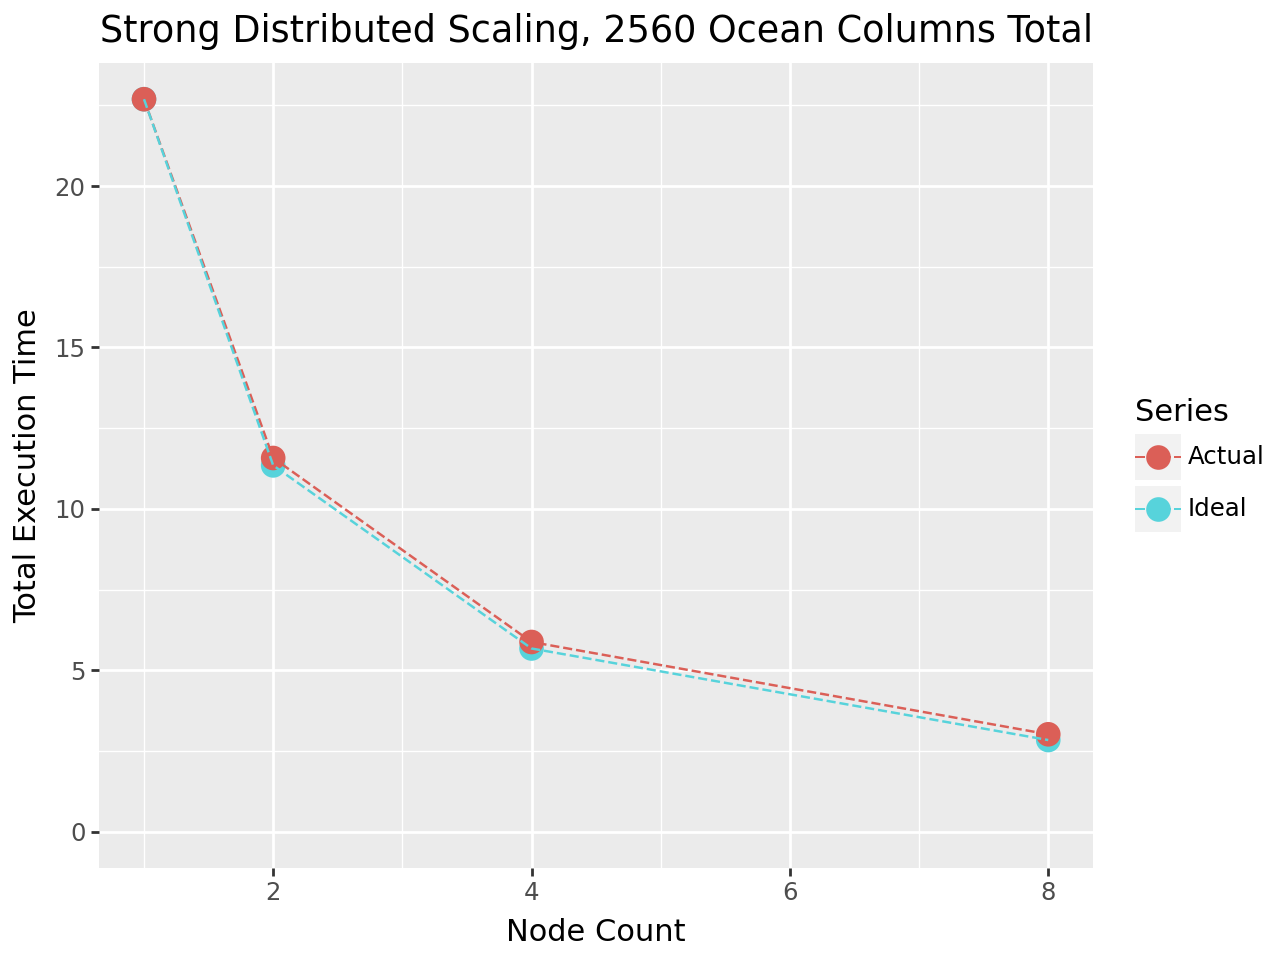

In [19]:
# Strong Scaling plots

one_node_time = strong_data[strong_data['NodeCount'] == 1]['Time'].values[0]

strong_data['Ideal'] = one_node_time / strong_data['NodeCount']

melted = pd.melt(strong_data, id_vars=['NodeCount'], value_vars=['Ideal', 'Time'], var_name='Series', value_name='Total Execution Time')
melted['Series'] = melted['Series'].str.replace('Time', 'Actual')

print(melted)
p = ggplot(melted, aes(x='NodeCount', y='Total Execution Time', color='Series')) + geom_point(size=4)
p = p + geom_line(linetype='dashed')
p = p + labs(x='Node Count', y='Total Execution Time', title='Strong Distributed Scaling, 2560 Ocean Columns Total')
p = p + scale_y_continuous(limits=(0,None))
p